# TalkingData AdTracking Fraud Detection Challenge

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, **you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad.** To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

In [1]:
import pandas as pd

df = pd.read_csv('train_all.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 76 columns):
record              1500000 non-null int64
channelIp10s        1500000 non-null int64
channelIp3s         1500000 non-null int64
channelApp10s       1500000 non-null int64
channelApp3s        1500000 non-null int64
channelDevice10s    1500000 non-null int64
channelDevice3s     1500000 non-null int64
channelOs10s        1500000 non-null int64
channelOs3s         1500000 non-null int64
osIp10s             1500000 non-null int64
osIp3s              1500000 non-null int64
osApp10s            1500000 non-null int64
osApp3s             1500000 non-null int64
osDevice10s         1500000 non-null int64
osDevice3s          1500000 non-null int64
osChannel10s        1500000 non-null int64
osChannel3s         1500000 non-null int64
deviceIp1s          1500000 non-null int64
deviceApp1s         1500000 non-null int64
deviceOs1s          1500000 non-null int64
deviceChannel1s     1500000

In [2]:
#get y
y = df.is_attributed.values

#get X and drop y 
X = df.drop(columns=['record', 'click_time', 'is_attributed', 'ip'])
X.hour = X.hour.astype('category')
X.channel = X.channel.astype('category')
X.os = X.os.astype('category')
X.device = X.device.astype('category')
X.app = X.app.astype('category')

print(y[:10])
print(X.iloc[:5,21:40])

[0 0 0 0 0 0 0 0 0 0]
   appIp3s  appDevice10s  appDevice3s  appOs10s  appOs3s  appChannel10s  \
0        1             1            1         1        1              1   
1        2             1            1         2        2              2   
2        1             1            1         1        1              1   
3        2             2            2         2        2              2   
4        1             1            1         1        1              1   

   appChannel3s  ipApp10s  ipApp3s  ipDevice10s  ipDevice3s  ipOs10s  ipOs3s  \
0             1         1        1            1           1        1       1   
1             2         1        1            1           1        1       1   
2             1         1        1            1           1        1       1   
3             2         1        1            1           1        1       1   
4             1         1        1            1           1        1       1   

   ipChannel10s  ipChannel3s hour  hourAttrib 

In [3]:
X = X.drop(columns=['hour', 'channel', 'os', 'device', 'app'])

### Downsampling

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000000)

goods = (y_train==1)

X_train_goods = X_train[goods]
y_train_goods = y_train[goods]

X_train_bads = X_train[~goods]
y_train_bads = y_train[~goods]

index = np.random.choice(range(len(y_train_bads)), len(y_train_goods)*3)

print(len(y_train_goods), len(y_train_bads), len(index))

X_train = pd.concat( [X_train_goods,X_train_bads.iloc[index,:]], axis=0)
y_train = np.hstack([y_train_goods,y_train_bads[index]])

print(len(y_train))
X_train.info()



/Users/simba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


3450 996550 10350
13800
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13800 entries, 1132289 to 1209444
Data columns (total 67 columns):
channelIp10s        13800 non-null int64
channelIp3s         13800 non-null int64
channelApp10s       13800 non-null int64
channelApp3s        13800 non-null int64
channelDevice10s    13800 non-null int64
channelDevice3s     13800 non-null int64
channelOs10s        13800 non-null int64
channelOs3s         13800 non-null int64
osIp10s             13800 non-null int64
osIp3s              13800 non-null int64
osApp10s            13800 non-null int64
osApp3s             13800 non-null int64
osDevice10s         13800 non-null int64
osDevice3s          13800 non-null int64
osChannel10s        13800 non-null int64
osChannel3s         13800 non-null int64
deviceIp1s          13800 non-null int64
deviceApp1s         13800 non-null int64
deviceOs1s          13800 non-null int64
deviceChannel1s     13800 non-null int64
appIp10s            13800 non-null int6

In [6]:
#Grid search cross-validation
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

steps = [('scaler', StandardScaler()),('knn', KNeighborsClassifier())]#(kernel='linear', probability=True))]

pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(1,50)}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
knn_cv = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv)

knn_cv.fit(X_train, y_train)
print(knn_cv.best_params_)
#print(knn_cv.cv_results_)

{'knn__n_neighbors': 49}


In [7]:
knn = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['knn__n_neighbors'])
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('score: {}'.format(knn.score(X_test, y_test)))

score: 0.955164


In [8]:
knn_cv.best_params_

{'knn__n_neighbors': 49}

### ROC Curve and AUC

AUC: 0.9449383682643336


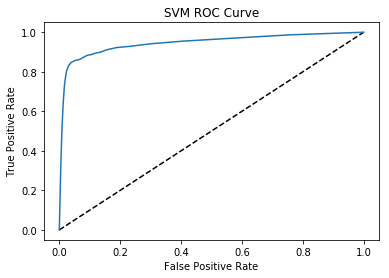

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

y_pred_prob = knn.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: {}'.format(auc))

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='kNN ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('kNN ROC curve')
plt.show()

[[476075  22155]
 [   263   1507]]
             precision    recall  f1-score   support

          0       1.00      0.96      0.98    498230
          1       0.06      0.85      0.12      1770

avg / total       1.00      0.96      0.97    500000



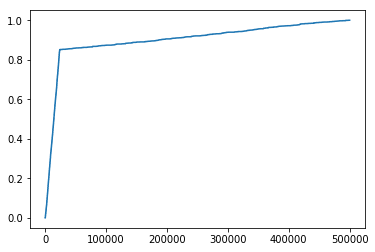

0.944938368264 0.859322033898 0.851412429379 0.955532585352 0.0636886146564


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

c_mat = confusion_matrix(y_test, y_pred)
print(c_mat)
print(classification_report(y_test, y_pred))

#fdr score
order = np.argsort(-y_pred)
fdr_arr = np.cumsum(y_test[order])/np.sum(y_test)
fdr_percent = np.arange(1,len(y_test)+1).astype(float)/len(y_test)

plt.plot(range(len(y_test)), fdr_arr)
plt.show()

fdr_rate = 0.1
fdr_arr = np.vstack([fdr_percent, fdr_arr]).T
fdr_arr = fdr_arr[fdr_percent < fdr_rate,:]
fdr_arr = fdr_arr[np.argsort(-fdr_arr[:,0])]
fdr = fdr_arr[0,1]

auc = roc_auc_score(y_test, y_pred_prob)
specificity = 1 - c_mat[0][1] / (c_mat[0][0]+c_mat[0][1])
sensitivity = c_mat[1][1] / (c_mat[1][0]+c_mat[1][1]) #Recall
precision = c_mat[1][1] / (c_mat[0][1]+c_mat[1][1]) #Recall
print(auc, fdr, sensitivity, specificity, precision)